## Plots
This notebook shows some examples of plotting the outputs from `testprocessor.TestProcessor`. Make sure to run that first (see `local.sh`). 

The histograms in `TestProcessor` use the "Hist" package ([documentation](https://hist.readthedocs.io/en/latest/)), which is a thin wrapper around boost-histogram ([documentation](https://boost-histogram.readthedocs.io/en/latest/)) that provides a few extra features, including named axes and quick plotting functions. 

A particularly important technique is indexing, or slicing. boost-histogram implements the UHI and UHI+ syntaxes ("universal histogram indexing"). These correspond to ROOT functions like `ProjectionX()`, `Rebin()`, or `GetBinContent()`, but using syntax inspired by numpy array indexing. For more information, [read this](https://boost-histogram.readthedocs.io/en/latest/notebooks/BoostHistogramHandsOn.html?highlight=uhi#4:-UHI).

In [1]:
import numpy as np
import awkward as ak
import json
import copy
from collections import defaultdict
import hist
import time
from pprint import pprint
import sys
from coffea import util
from coffea import processor
from coffea import hist as chist
from coffea import nanoevents
import mplhep
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import boost_histogram as bh

mplhep.style.use("CMS")
print("Done")

import uproot
uproot.open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

def set_axis_font_size(ax, fontsize):
    ax.xaxis.label.set_fontsize(fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    

Done


In [2]:
# Look at the histogram file
coffea_output = util.load("hists.coffea")
pprint(coffea_output.keys())
hists = coffea_output["r352567_MinimumBias"]
pprint(hists.keys())

dict_keys(['r352567_MinimumBias'])
dict_keys(['nevents', 'eventq', 'sumq', 'sumq_depthmap', 'interesting_events'])


In [3]:
# Look at histogram axes
print([axis.name for axis in hists["eventq"].axes])

['is_bx1', 'eventq']


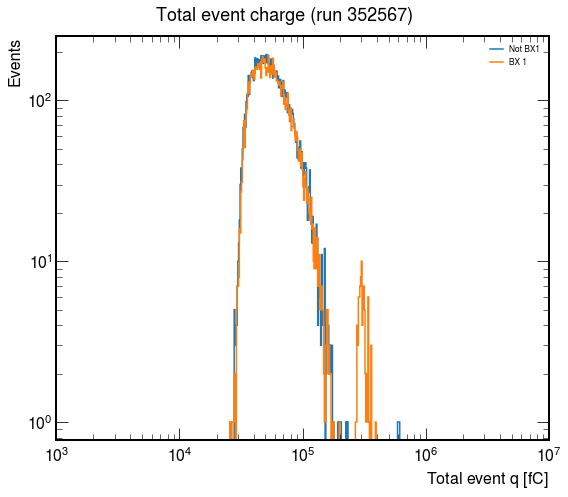

In [4]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,7))
hh = hists["eventq"]
hists["eventq"].plot(ax=ax1, overlay="is_bx1")
ax1.set_xscale("log")
ax1.set_xlim(1.e3, 1.e7)
set_axis_font_size(ax1, 16)
ax1.set_yscale("log")
ax1.set_ylabel("Events")
fig1.suptitle(f"Total event charge (run {352567})", fontsize=18)
handles, labels = ax1.get_legend_handles_labels()
labels[1] = "BX 1"
labels[0] = "Not BX1"
ax1.legend(handles=handles, labels=labels)
plt.tight_layout()


In [5]:
print([axis.label for axis in hists["sumq"].axes])

['subdet', 'is_bx1', 'Channel $\\Sigma_{TS} q$ [fC]']


Text(0.5, 0.98, 'Channel $\\Sigma_{TS} (q)$')

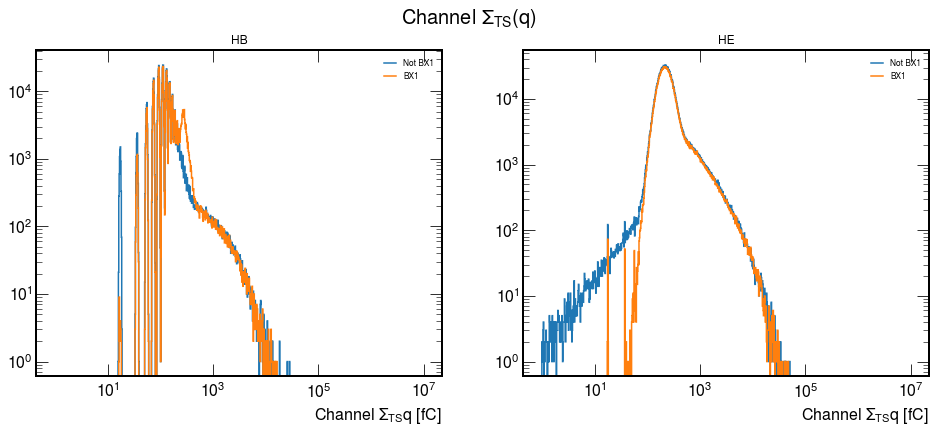

In [6]:
figs2, axs2 = plt.subplots(1, 2, figsize=(16, 6))
h_sumq = {}
for iax, subdet in enumerate(["HB", "HE"]):
    h_sumq[subdet] = hists["sumq"][{"subdet": subdet}]
    h_sumq[subdet].plot(ax=axs2[iax], overlay="is_bx1")
    axs2[iax].set_xscale("log")
    axs2[iax].set_yscale("log")
    axs2[iax].legend(labels=("Not BX1", "BX1"))
    axs2[iax].set_title(subdet)
    set_axis_font_size(axs2[iax], 16)
figs2.suptitle(r"Channel $\Sigma_{TS} (q)$", fontsize=20)

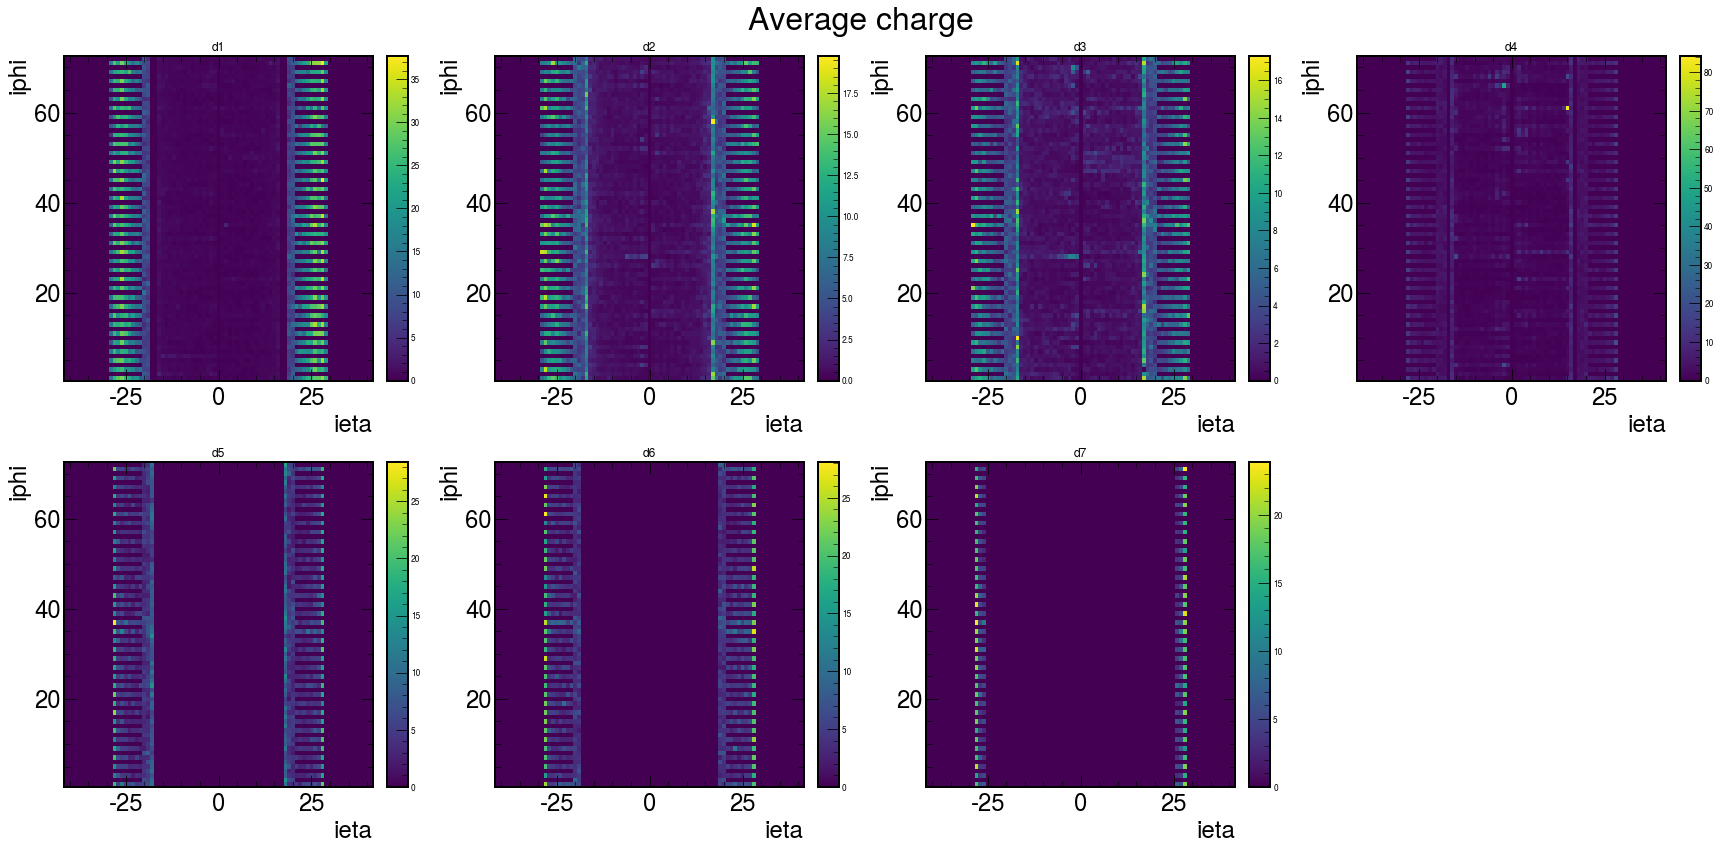

In [7]:
figs3, axs3 = plt.subplots(2, 4, figsize=(24, 12))
figs3.delaxes(axs3[1, 3])
h_sumq_depthmap = {}
for iax, depth in enumerate(range(1, 8)):
    h_sumq_depthmap[depth] = hists["sumq_depthmap"][{"depth": bh.loc(depth)}] / hists["nevents"]
    h_sumq_depthmap[depth]
    #print(axs3.flat[iax])
    h_sumq_depthmap[depth].plot(ax=axs3.flat[iax])
    #axs3.flat[iax].set_xscale("log")
    #axs3.flat[iax].set_yscale("log")
    #axs3.flat[iax].legend(labels=("Not BX1", "BX1"))
    #axs3.flat[iax].set_title(subdet)
    axs3.flat[iax].set_title(f"d{depth}")
    set_axis_font_size(axs3.flat[iax], 24)
figs3.suptitle("Average charge", fontsize=32)
plt.tight_layout()


In [8]:
# Inspecting individual events
interesting_events_list = hists["interesting_events"]
print(interesting_events_list[:10])
print(f"Interesting events: {len(interesting_events_list)} / {hists['nevents']} = {100.*len(interesting_events_list)/hists['nevents']} %")



[44411865, 44641329, 44733249, 44010765, 44355989, 44133499, 44246068, 44094689, 44622846, 44516252]
Interesting events: 93 / 21104 = 0.44067475360121305 %


In [10]:
# Load events using NanoEventsFactory (same thing as used by processor w/NanoAODSchema)
# Warning: don't load too many events at once! At some point, the whole array will have to be loaded from disk. 
#       If you try to load >1000 events, this will probably crash due to running out of memory.
events = nanoevents.NanoEventsFactory.from_root('root://eoscms.cern.ch//store/group/dpg_hcal/comm_hcal/PFG/hcalnano//r352567_MinimumBias/hcalnano_r352567.subjob0.root', 
                                     metadata={"dataset": "352567"}, 
                                     entry_stop=1000).events()
interesting_events = events[np.isin(ak.to_numpy(events.event),  interesting_events_list)]
print(len(interesting_events))


5


In [11]:
depthmap = hist.Hist(
            hist.axis.IntCategory([], name="bx", growth=True),
            hist.axis.IntCategory([], name="event", growth=True),
            hist.axis.Regular(35, -17.5, 17.5, name="ieta", label=r"ieta"),
            hist.axis.Regular(72, 0.5, 72.5, name="iphi", label=r"iphi"),
            hist.axis.Regular(4, 0.5, 4.5, name="depth", label=r"depth"),
            )

print("Processing digis")
digis = interesting_events["HBDigis"]
print("A")
validdigis = digis[digis.valid]
print("B")
digi_sumq = ak.sum([validdigis[f"fc{iTS}"] - validdigis[f"pedestalfc{iTS}"] for iTS in range(8)], axis=0)
print("C")
digishape = ak.ones_like(validdigis.ieta)

print("Filling depthmap")
depthmap.fill(
    bx     = ak.flatten(interesting_events.bunchCrossing * digishape), 
    event  = ak.flatten(interesting_events.event * digishape), 
    ieta   = ak.flatten(validdigis.ieta), 
    iphi   = ak.flatten(validdigis.iphi), 
    depth  = ak.flatten(validdigis.depth), 
    weight = ak.flatten(digi_sumq)
)


Processing digis
A
B
C
Filling depthmap


Hist(
  IntCategory([1], growth=True, name='bx', label='bx'),
  IntCategory([4.44119e+07, 4.46413e+07, 4.42461e+07, 4.47332e+07, 4.40108e+07], growth=True, name='event', label='event'),
  Regular(35, -17.5, 17.5, name='ieta', label='ieta'),
  Regular(72, 0.5, 72.5, name='iphi', label='iphi'),
  Regular(4, 0.5, 4.5, name='depth', label='depth'),
  storage=Double()) # Sum: 1276943.1795196533

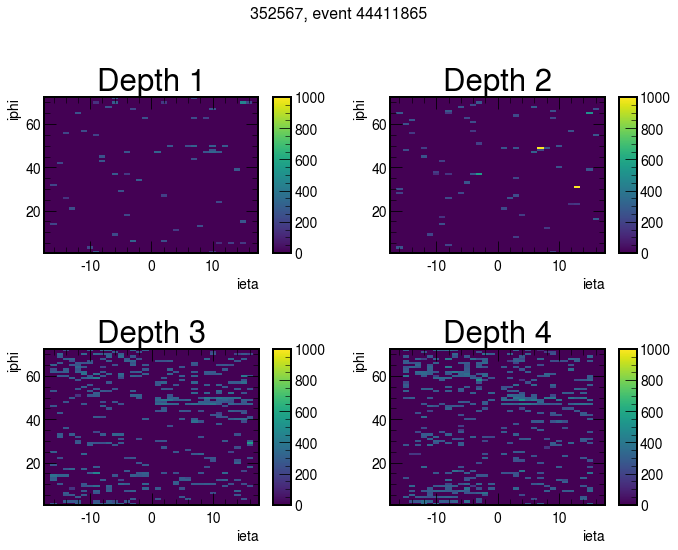

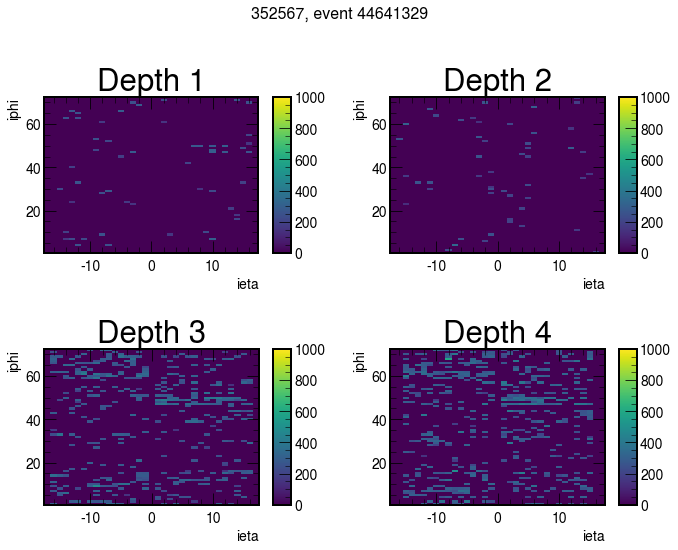

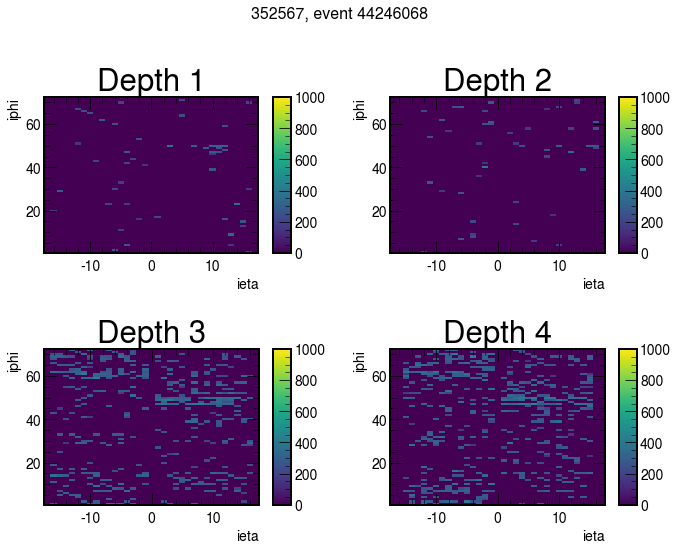

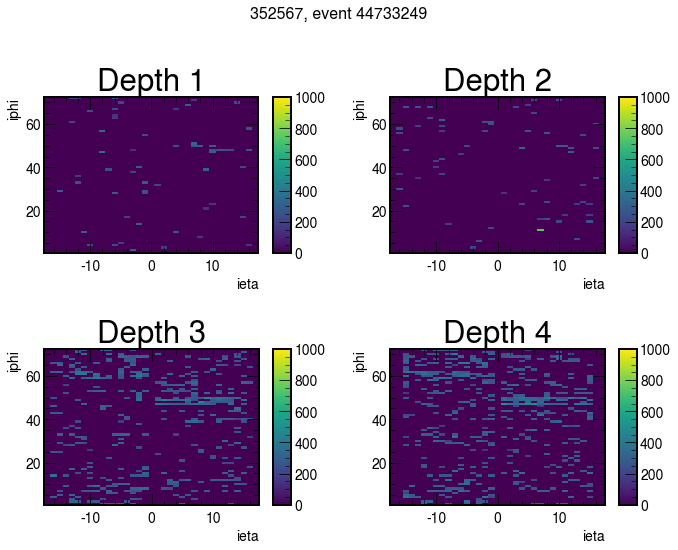

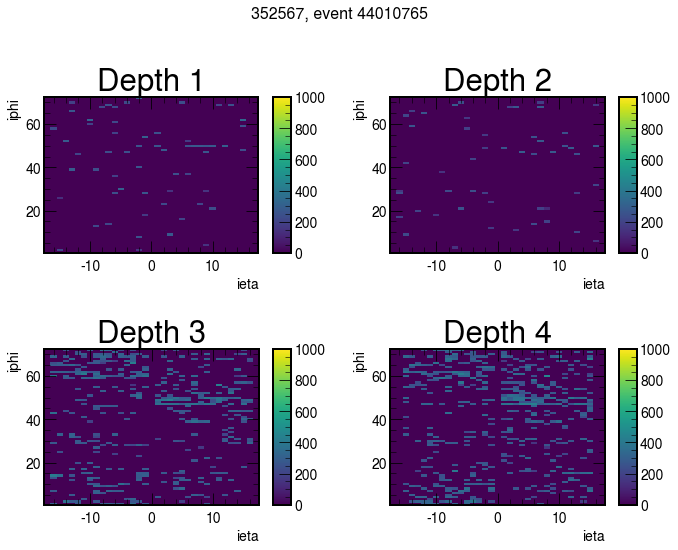

In [13]:
figs4 = {}
axs4 = {}
mplhep.style.use(mplhep.style.CMS)
for ievt in range(5):
    figs4[ievt], axs4[ievt] = plt.subplots(2, 2, figsize=(10,8))
    for idepth in range(4):
        pcm_objs = depthmap[{"bx": 0, "event": ievt, "depth": idepth}].plot(ax=axs4[ievt].flat[idepth], 
                                                                vmin=0, 
                                                                vmax=1000,)
        evtnum = depthmap.axes[1][ievt]
        figs4[ievt].suptitle(f'352567, event {evtnum}', fontsize=16)
        axs4[ievt].flat[idepth].xaxis.label.set_size(14)
        axs4[ievt].flat[idepth].yaxis.label.set_size(14)
        axs4[ievt].flat[idepth].tick_params(axis='x', labelsize=14)
        axs4[ievt].flat[idepth].tick_params(axis='y', labelsize=14)
        axs4[ievt].flat[idepth].set_title(f"Depth {idepth+1}")
        colorbar = pcm_objs[1]
        colorbar.ax.yaxis.label.set_size(14)
        colorbar.ax.tick_params(axis="y", labelsize=14)

        plt.tight_layout()